# Portfolio Analysis of Real Estate sector

### Stocks under observation:

    - Vornado Realty Trust (NYSE: VNO)
    - Simon Property Group Inc. (NYSE: SPG)
    - Host Hotels & Resorts Inc. (NYSE: HST)
    - BROOKFIELD PROPERTY (NYSE: BPY)
    - HOWARD HUGHES CORP. (NYSE: HHC)
    - ZILLOW GROUP (NYSE: Z) 



In [12]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [13]:
estate = ['VNO', 'SPG', 'HST', 'BPY','HHC', 'Z' ]
data = pd.DataFrame()
for i in range(len(estate)):
    
    df = wb.DataReader(estate[i], data_source='yahoo', start='2019-1-1', end = '2020-5-1')
    df['stock'] = estate[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,BPY,HHC,HST,SPG,VNO,Z
Date,,,,,,
2019-01-02,14.789576,96.620003,15.523476,154.529343,54.787186,30.350000
2019-01-03,15.155882,96.500000,15.485593,154.398254,54.641960,29.920000
2019-01-04,15.522188,99.580002,15.978099,156.748810,55.558712,30.799999
2019-01-07,15.760284,101.820000,16.082283,158.397034,56.620686,30.850000
2019-01-08,15.531345,104.320000,16.480078,162.180420,58.109272,31.760000


Text(0, 0.5, 'price in $')

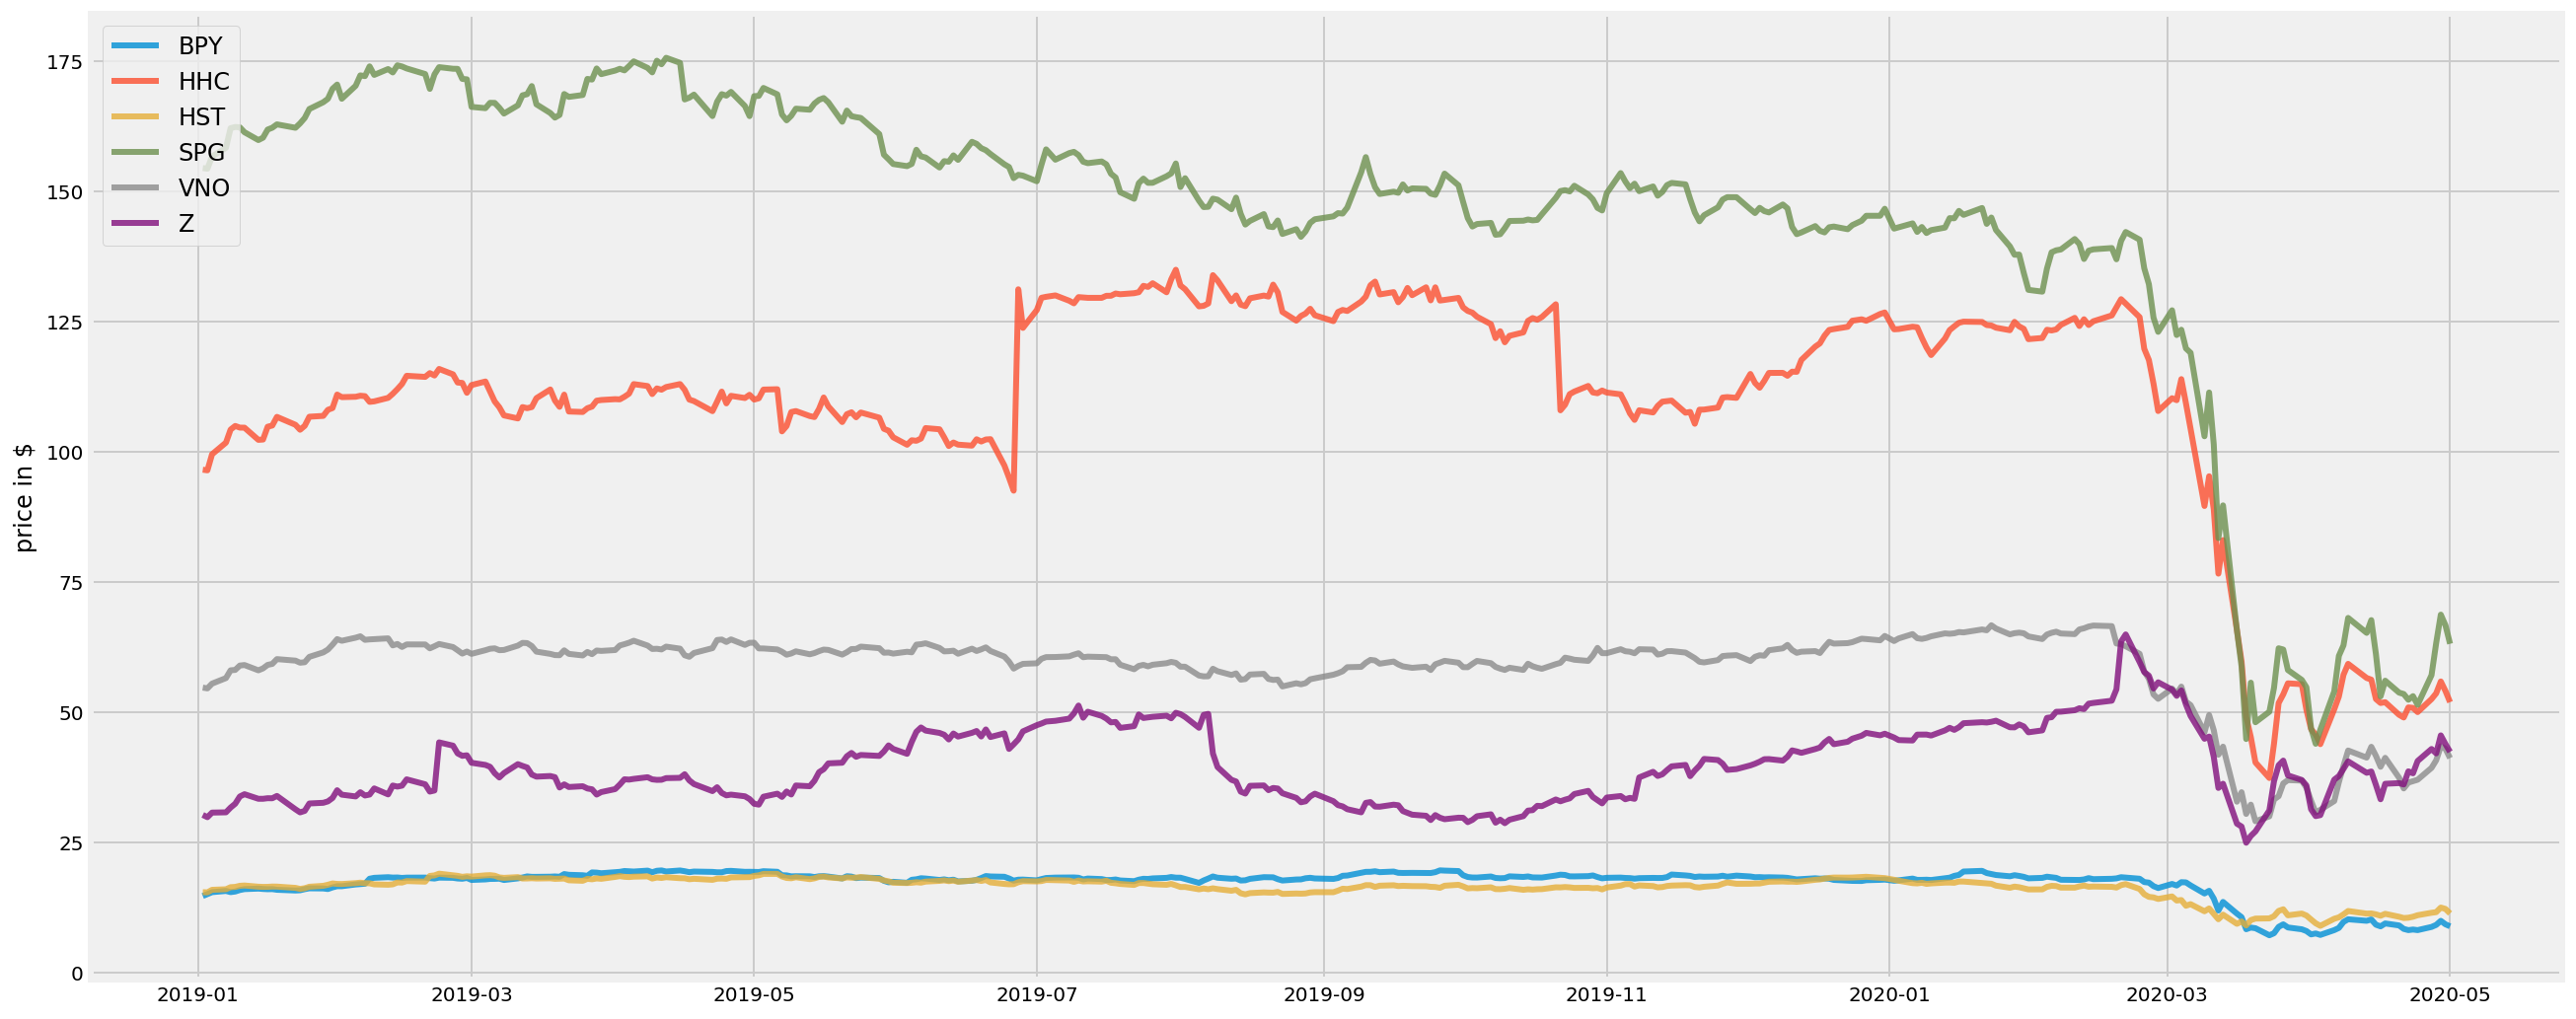

In [14]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

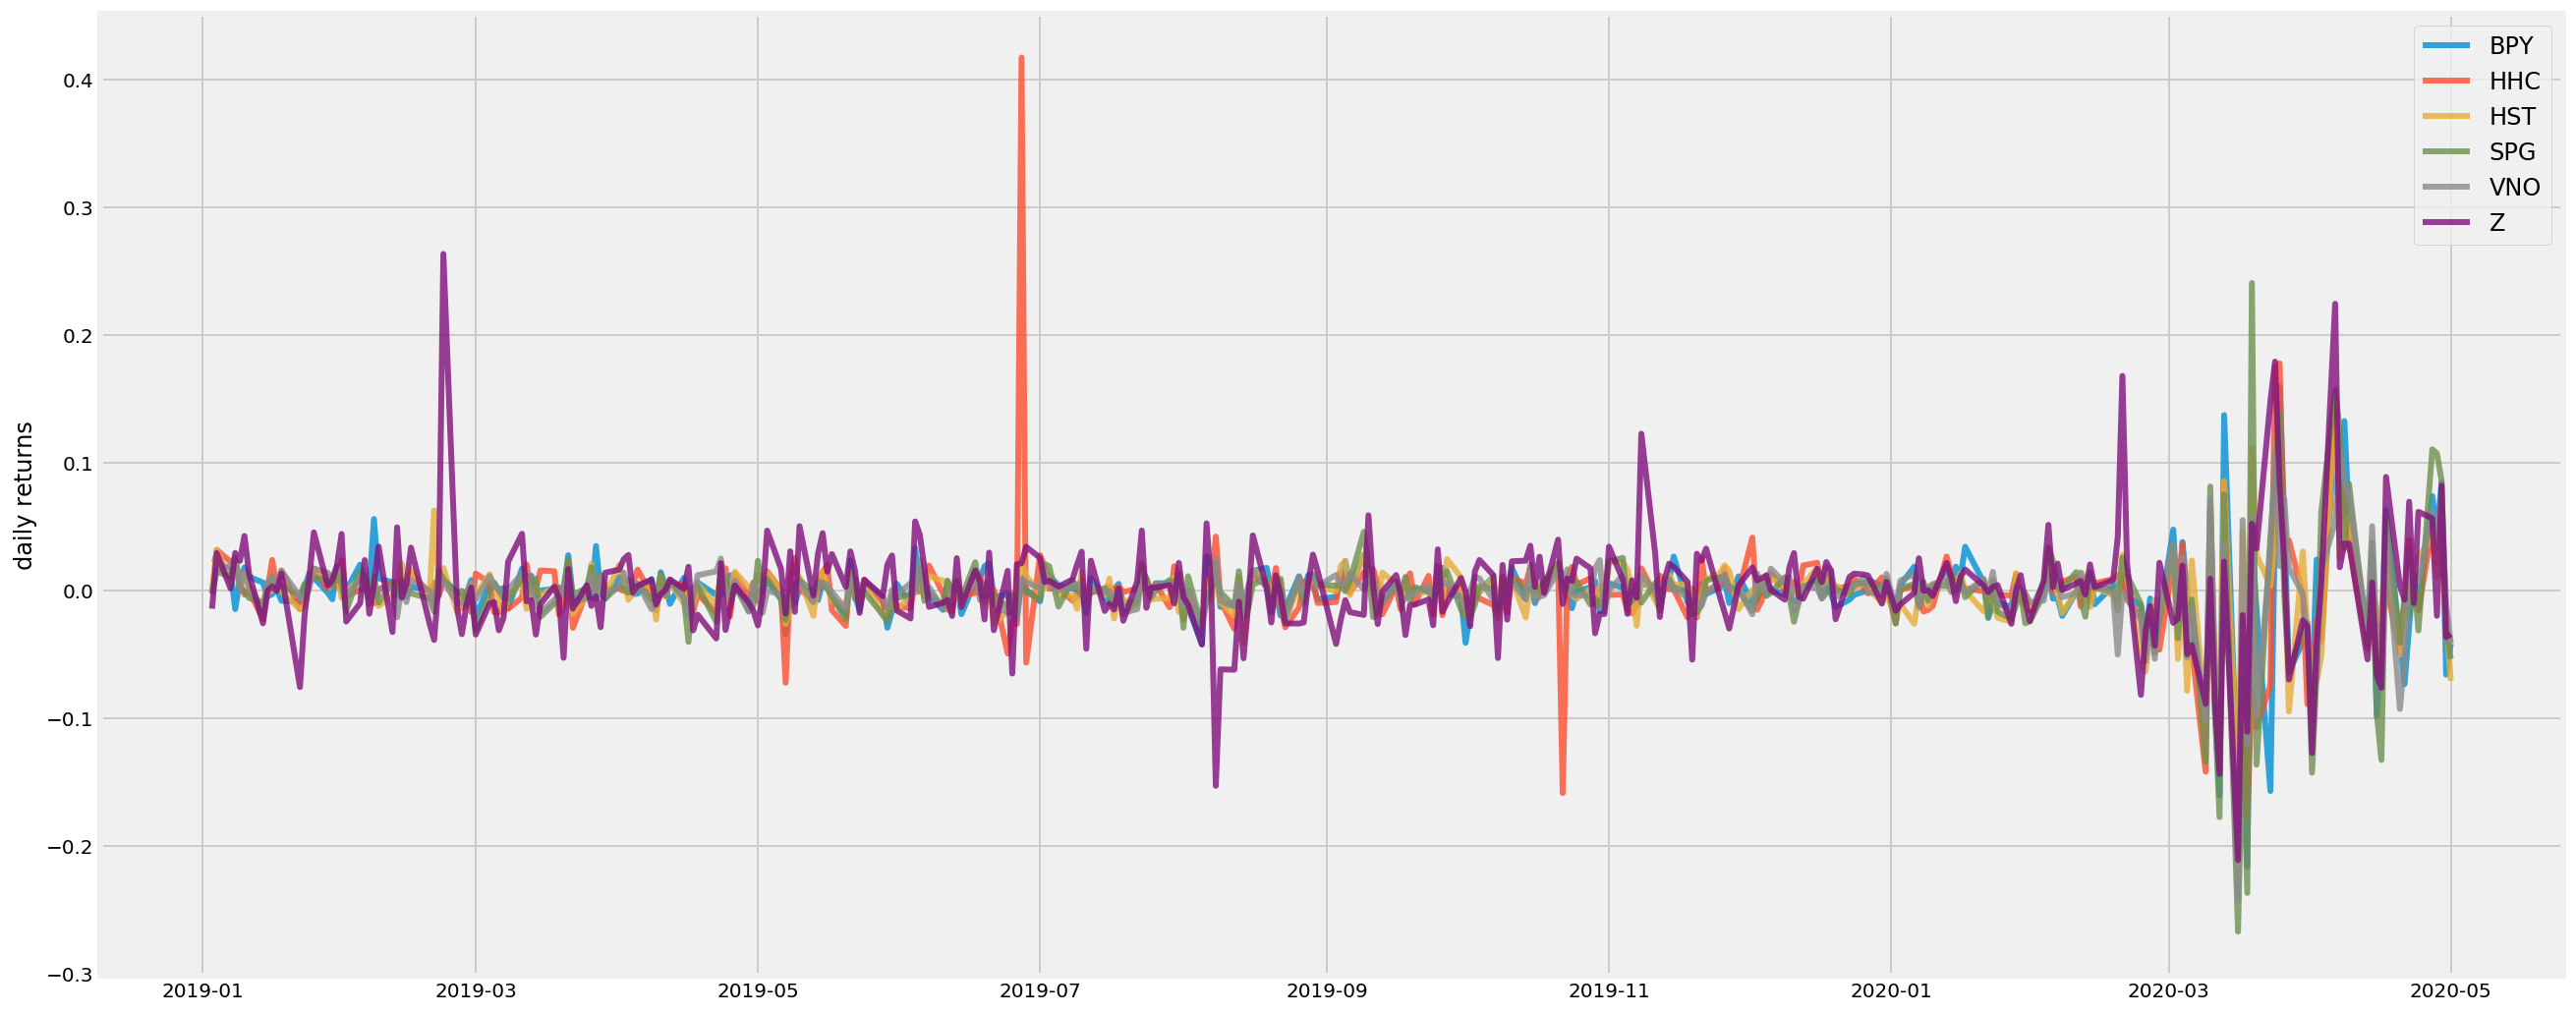

In [15]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

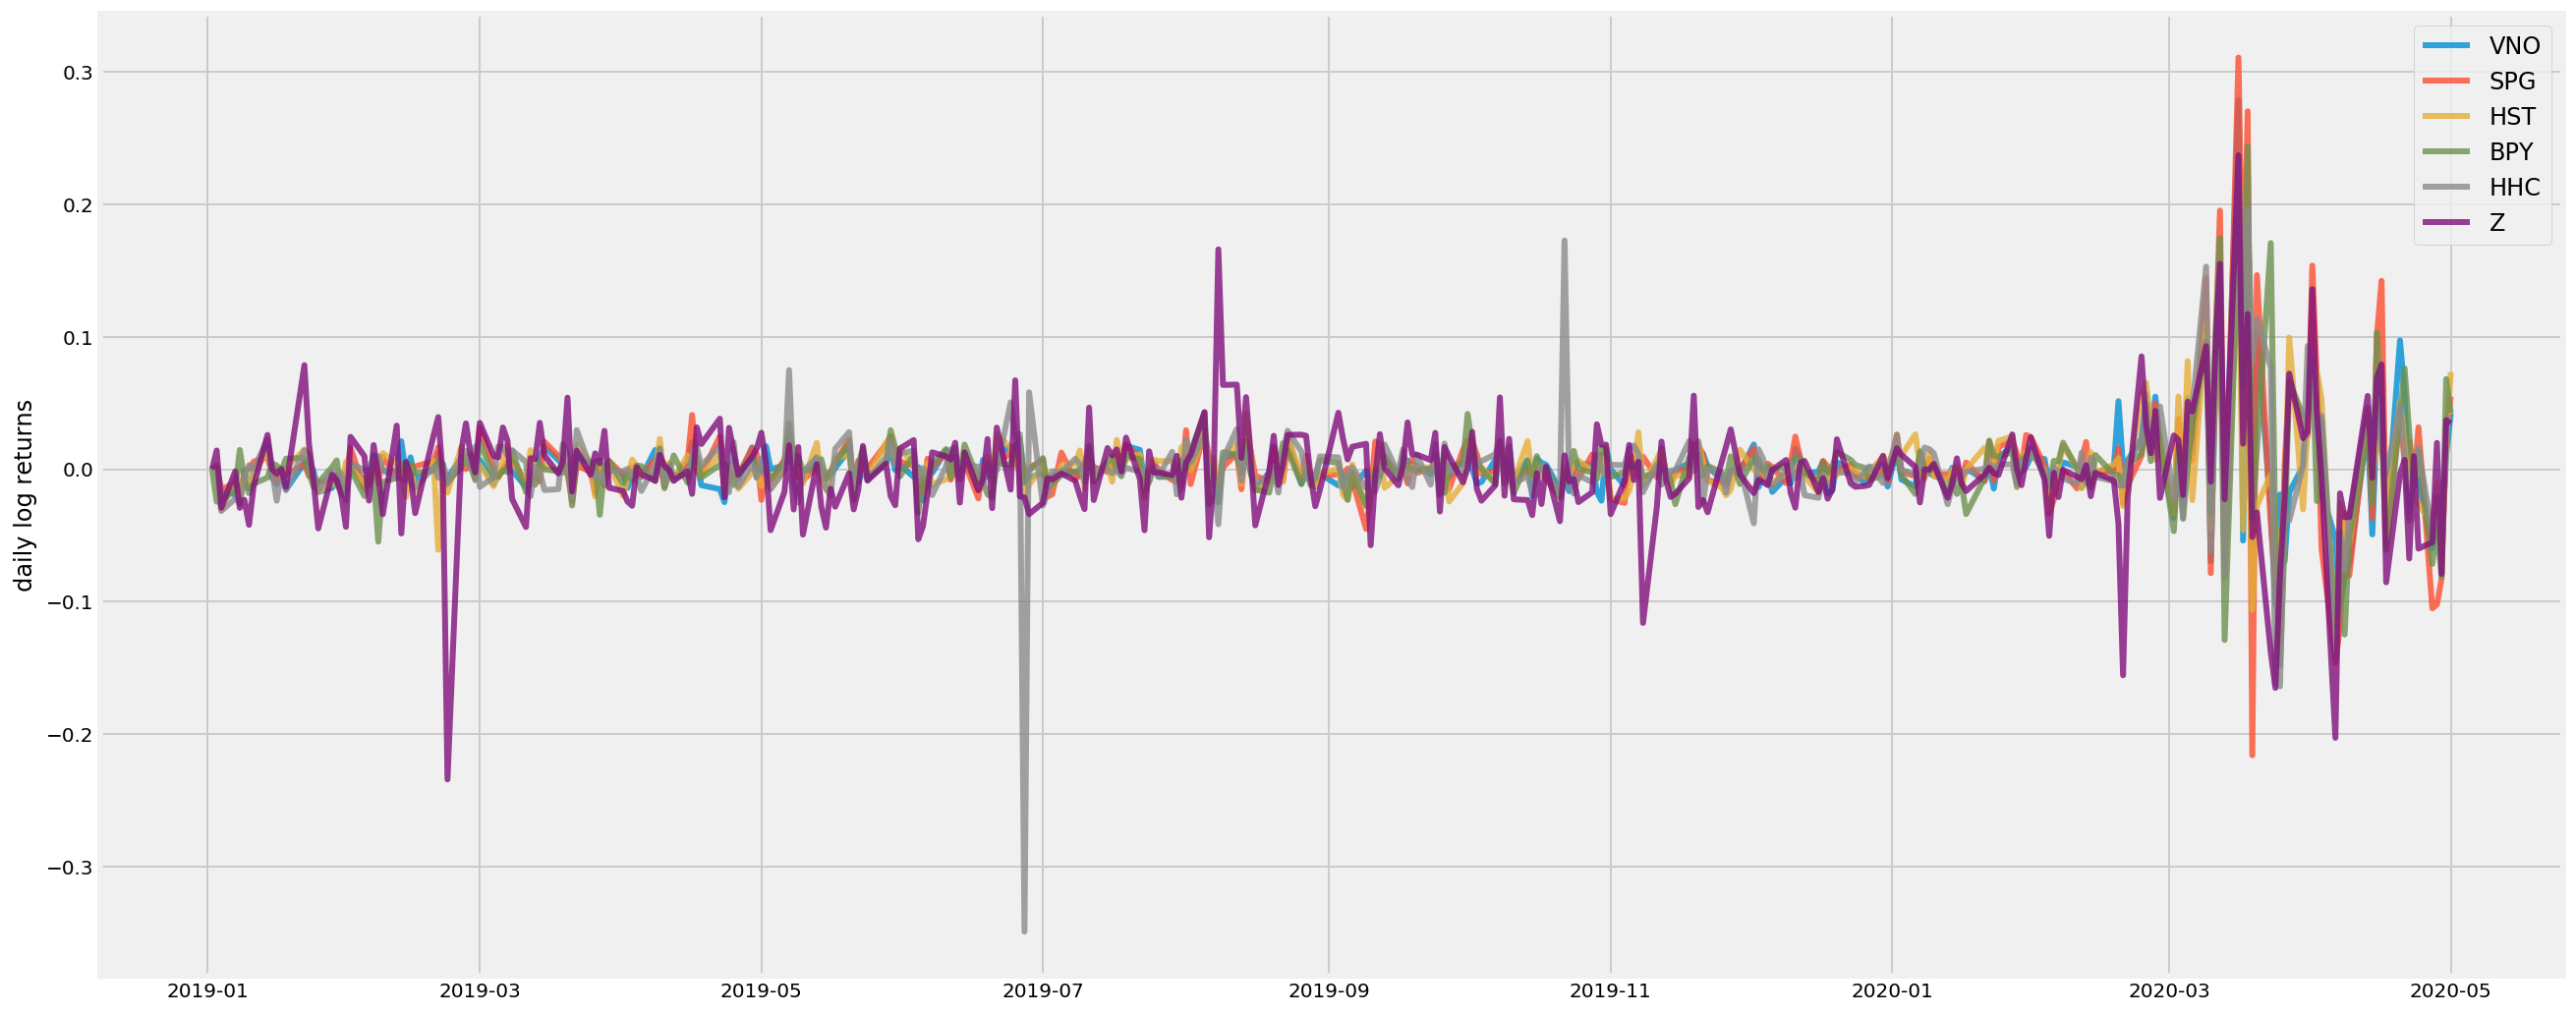

In [16]:
log = pd.DataFrame(columns = estate, index = table.index)

for i in range(len(estate)):
    log_list = []
    for j in range(len(table[estate[i]])):
        if(j+1<len(table[estate[i]])):
            log_returns =  np.log(table[estate[i]][j]) - np.log(table[estate[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[estate[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

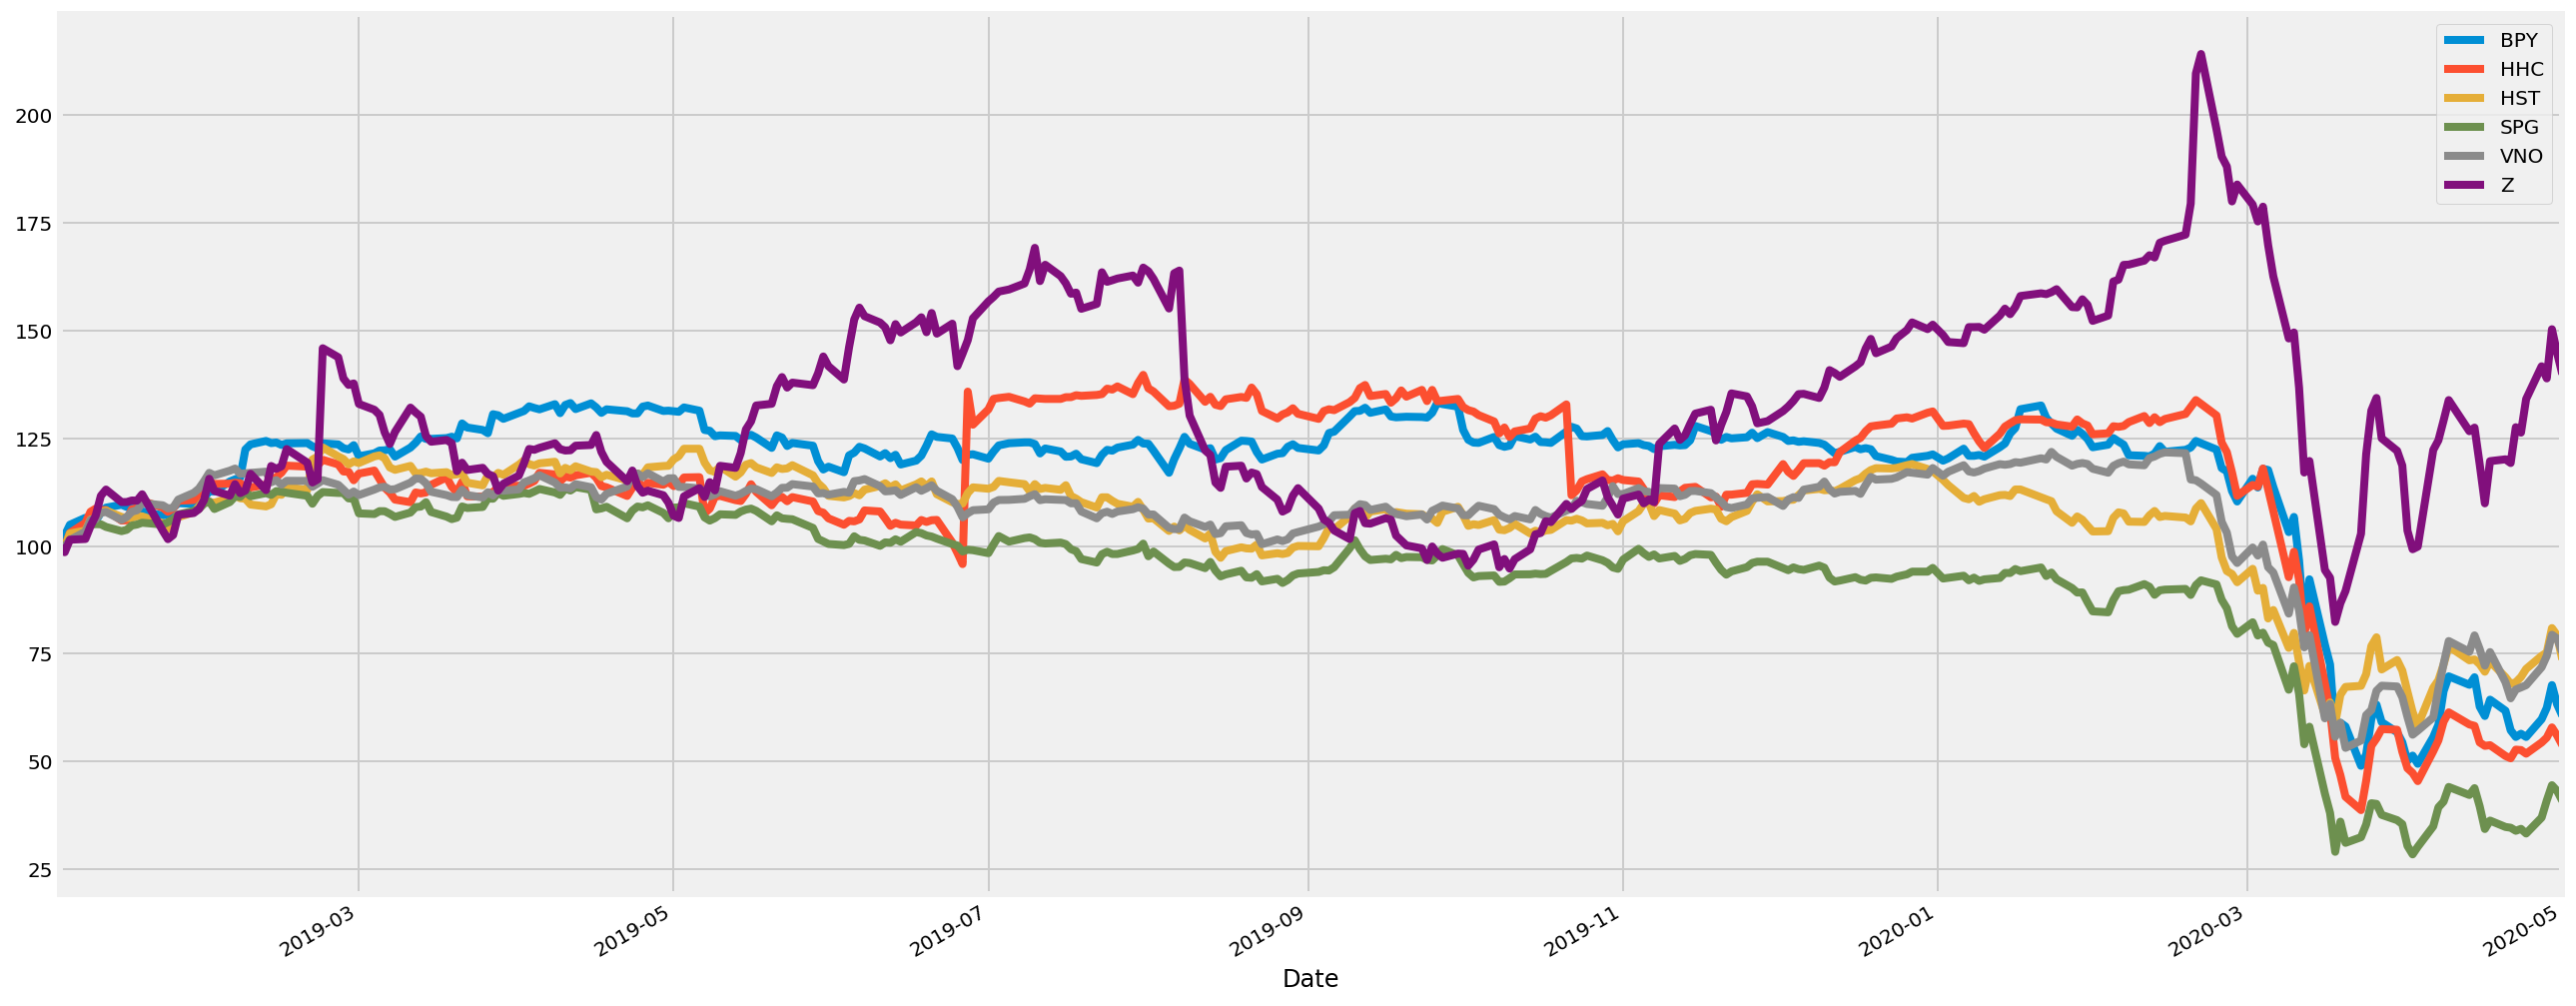

In [17]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [18]:
returns

,BPY,HHC,HST,SPG,VNO,Z
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.024768,-0.001242,-0.002440,-0.000848,-0.002651,-0.014168
2019-01-04,0.024169,0.031917,0.031804,0.015224,0.016777,0.029412
2019-01-07,0.015339,0.022494,0.006520,0.010515,0.019114,0.001623
2019-01-08,-0.014526,0.024553,0.024735,0.023885,0.026291,0.029498
...,...,...,...,...,...,...
2020-04-27,0.074029,0.049910,0.042342,0.110701,0.061424,0.056627
2020-04-28,0.044068,0.020916,0.010372,0.107361,0.036668,-0.019763
2020-04-29,0.084416,0.042466,0.075278,0.086373,0.065688,0.082068


In [19]:
log.mean()*252

VNO    0.212590
SPG    0.670560
HST    0.228928
BPY    0.375028
HHC    0.464657
Z     -0.251824
dtype: float64

In [20]:
log.std()*252**0.5

VNO    0.455244
SPG    0.645858
HST    0.419000
BPY    0.525425
HHC    0.629375
Z      0.656368
dtype: float64

In [21]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0073

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.57


             BPY   HHC   HST    SPG   VNO      Z
allocation  1.21  5.19  1.94  10.94  8.95  71.78
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.15
Annualised Volatility: 0.4


              BPY   HHC   HST   SPG    VNO     Z
allocation  17.19  0.38  54.3  0.07  27.71  0.35


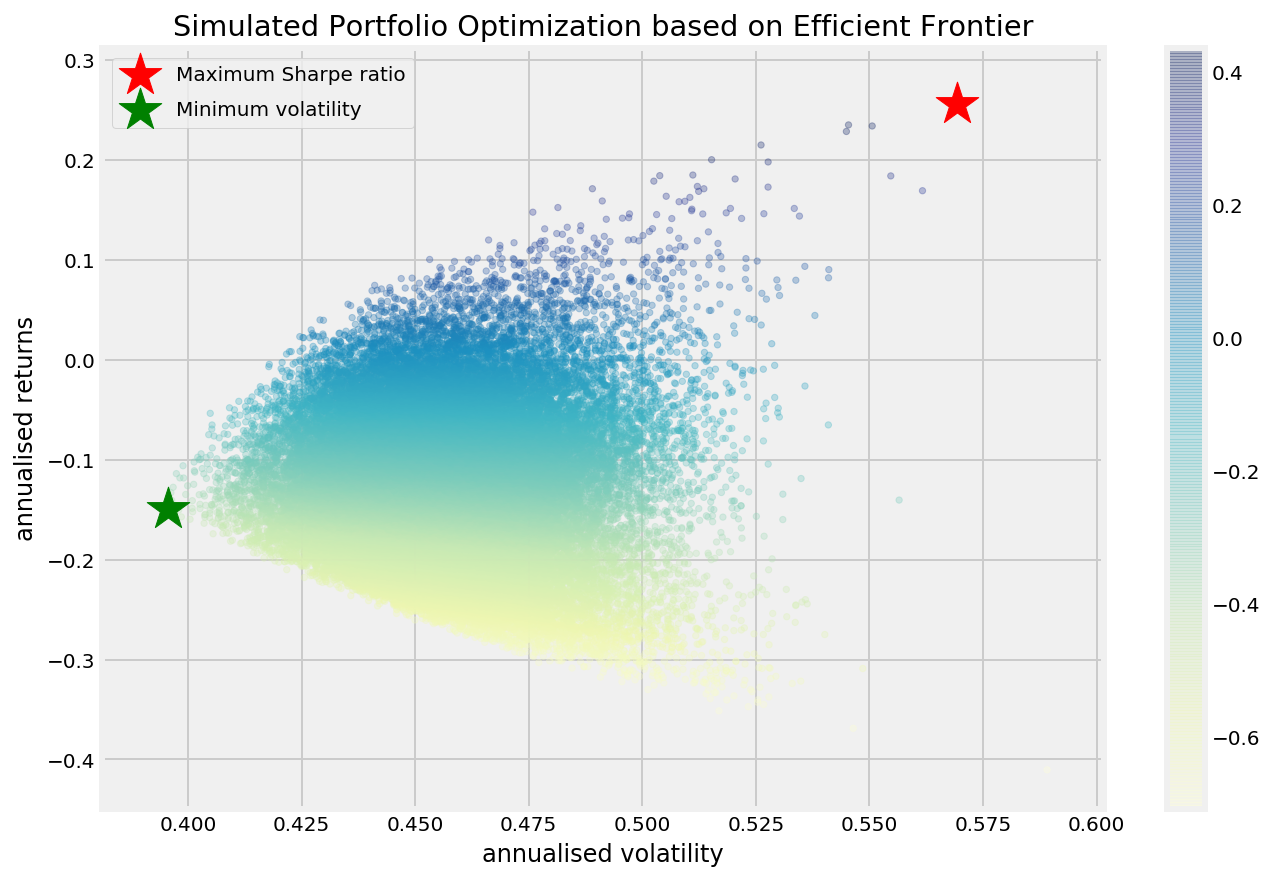

In [22]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)